<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#Lasso" data-toc-modified-id="Lasso-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Lasso</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd

import os
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import lightgbm as lgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

pd.options.mode.chained_assignment = None

In [2]:
if os.path.exists('/datasets/taxi.csv'):
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
else:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


## Анализ

Данные загружены, проведем анализ.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
print(df.index.is_monotonic)

True


Данные отсортированы по дате. Данные представлены с 1 марта 2018 по 31 августа 2018 года. Незаполненных значений нет.

Построим график.

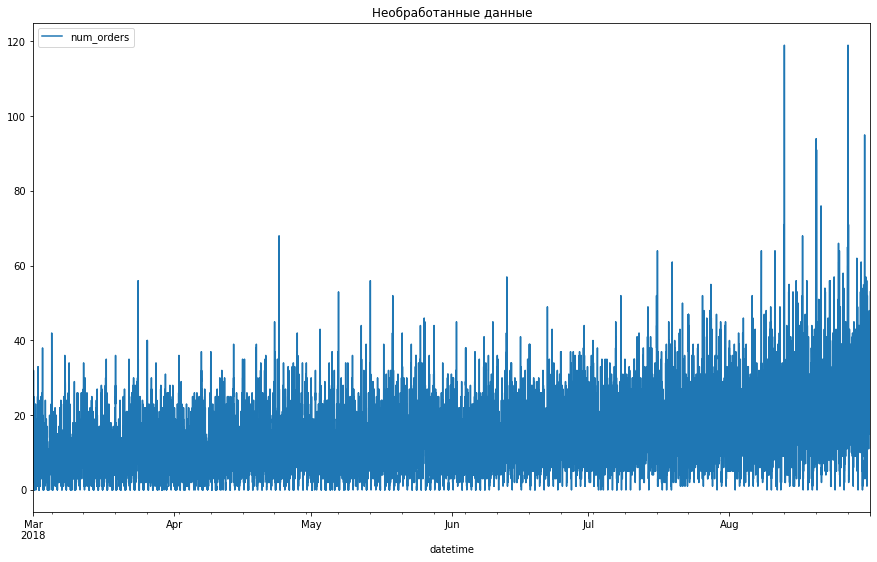

In [5]:
df.plot(figsize=(15,9), title='Необработанные данные');

С уверенностью сказать, что в данных присутсвует тренд или сезонность в таком масштабе нельзя. Изучим данные с помощью библиотеки seasonal_decompose.

Данные отсортированы, выполним ресэмплирование по часу и дню.

In [6]:
df_h = df.resample('1H').sum()
df_h

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [7]:
df_d = df.resample('1D').sum()
df_d

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259
...,...
2018-08-27,3936
2018-08-28,3357
2018-08-29,3762


In [8]:
decomposed = seasonal_decompose(df_h)

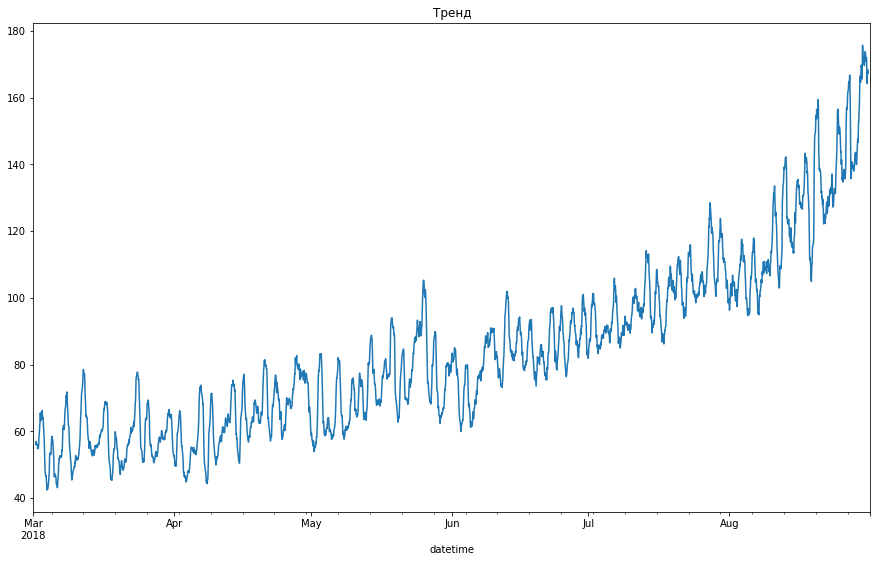

In [9]:
decomposed.trend.plot(figsize=(15,9), title='Тренд');

Есть тренд на увеличение количества заказов от месяца к месяцу. Поскольку данные предоставлены только за часть года, невозможно сказать, есть ли сезонная составляющая в росте количества поездок.

Оценим сезонную составляющую на более коротком промежутке времени, например, на 10 днях.

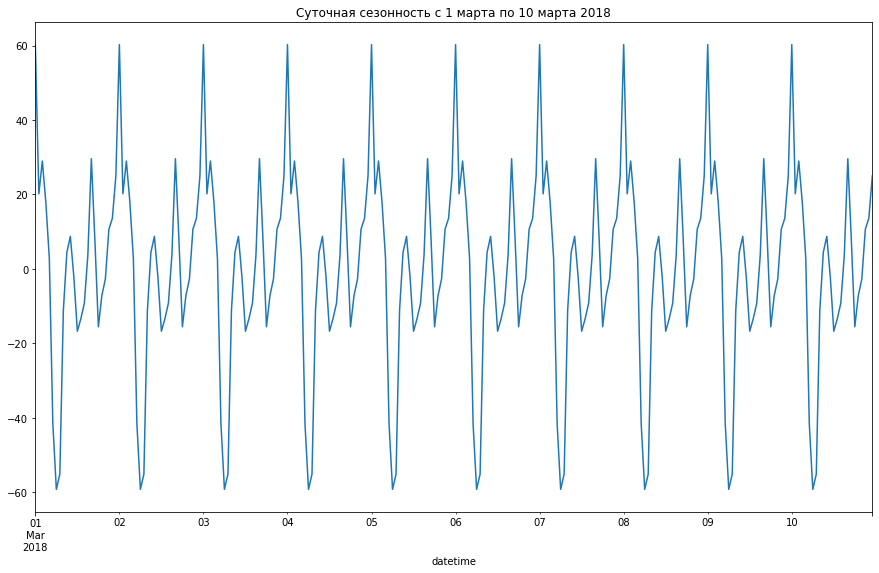

In [10]:
decomposed.seasonal['2018-03-01':'2018-03-10'].plot(figsize=(15,9), title='Суточная сезонность с 1 марта по 10 марта 2018');

Каждые сутки прослеживаются спады и всплески количества поездок.

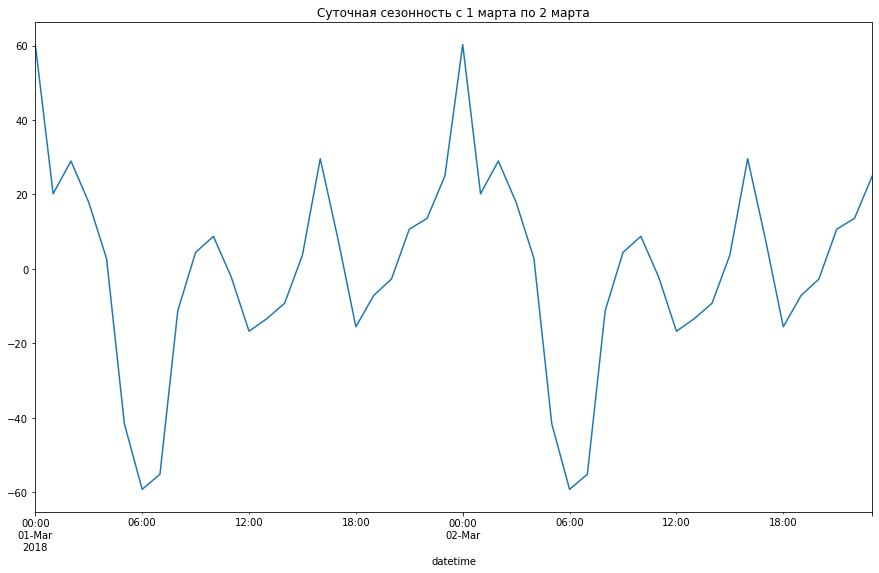

In [11]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(figsize=(15,9), title='Суточная сезонность с 1 марта по 2 марта');

Наибольшее количество поездок совершается около полуночи, наименьшее около 6 часов утра.

Рассмотрим сезонность на выборке, ресэплированной до дня.

In [12]:
decomposed_d = seasonal_decompose(df_d)

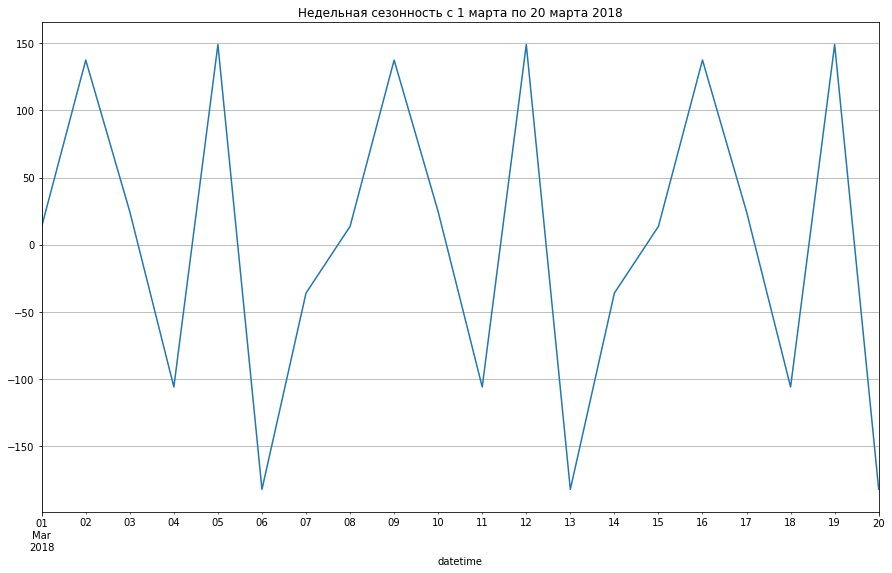

In [13]:
decomposed_d.seasonal['2018-03-01':'2018-03-20'].plot(figsize=(15,9), grid=True, title='Недельная сезонность с 1 марта по 20 марта 2018');

В воскресенья и вторники поездок меньше всего, а в понедельники и пятницы - больше всего.

**Выводы**
* Данные представлены с 1 марта 2018 по 31 августа 2018 года
* Наибольшее количество поездок совершается около полуночи, наименьшее около 6 часов утра.
* В воскресенья и вторники поездок меньше всего, а в понедельники и пятницы - больше всего
* Есть тренд на увеличение количества заказов от месяца к месяцу. Поскольку данные предоставлены только за часть года, невозможно сказать, есть ли сезонная составляющая в росте количества поездок.
* Незаполненных значений нет.

## Обучение

Напишем функцию по добавлению признаков в датасет. Добавим день, день недели и месяц.

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Обучим три модели: LinearRegression, Lasso, LightGBM.

### LinearRegression

Опишем модель.

In [16]:
regressor = LinearRegression()

param_grid = {
              
             }

tscv = TimeSeriesSplit(n_splits=5)

# инициализируем GridSearchCV
grid_search_lr = GridSearchCV(estimator = regressor, 
                           param_grid = param_grid, 
                           cv = tscv,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_root_mean_squared_error',
                          )

Запустим расчет на данных без масштабирования.

In [17]:
%%time

# без масштабирования
best_grid_search_lr = np.nan
best_rmse_lr = 1000
best_lag_lr = 0
best_rolling_lr = 0

for l in range(1, 101, 10): # lag   
    for r in range(1, 101, 10): # rolling
        
        df_copy = df_h.copy()
        
        make_features(df_copy, l, r)        
        train, test = train_test_split(df_copy, shuffle=False, test_size=0.1)
        
        train = train.dropna()

        features_train = train.drop(['num_orders'], axis=1)
        target_train = train['num_orders']
        
        grid_search_lr.fit(features_train, target_train)
        
        rmse = - grid_search_lr.best_score_        
        
        if rmse < best_rmse_lr:
            best_grid_search_lr = grid_search_lr.best_score_
            best_rmse_lr = rmse
            best_lag_lr = l
            best_rolling_lr = r
print(grid_search_lr.best_params_)
print(- grid_search_lr.best_score_, best_lag_lr, best_rolling_lr)

{}
24.25608586680768 81 61
CPU times: total: 19.6 s
Wall time: 32.2 s


Запустим расчет на данных с масштабированием.

In [22]:
%%time

# с масштабированием
best_grid_search_lr_1 = np.nan
best_rmse_lr_1 = 1000
best_lag_lr_1 = 0
best_rolling_lr_1 = 0

for l in range(1, 101, 10): # lag   
    for r in range(1, 101, 10): # rolling
        
        df_copy = df_h.copy()
        
        make_features(df_copy, l, r)        
        train, test = train_test_split(df_copy, shuffle=False, test_size=0.1)
        
        train = train.dropna()

        features_train = train.drop(['num_orders'], axis=1)
        target_train = train['num_orders']
        
        scaler = StandardScaler()
        scaler.fit(features_train)
        features_train = scaler.transform(features_train)
        
        grid_search_lr.fit(features_train, target_train)
        
        rmse = - grid_search_lr.best_score_        
        
        if rmse < best_rmse_lr_1:
            best_grid_search_lr_1 = grid_search_lr.best_score_
            best_rmse_lr_1 = rmse
            best_lag_lr_1 = l
            best_rolling_lr_1 = r
print(grid_search_lr.best_params_)
print(- grid_search_lr.best_score_, best_lag_lr_1, best_rolling_lr_1)

{}
24.256685031805905 81 11
CPU times: total: 20.6 s
Wall time: 21.2 s


In [24]:
print(f'Разницы в результатах модели с масштабированием и без, почти нет. Оптимальное значение лага и размера скользящего окна: {best_lag_lr} и {best_rolling_lr}/{best_rolling_lr_1}')

Разницы в результатах модели с масштабированием и без, почти нет. Оптимальное значение лага и размера скользящего окна: 81 и 61/11


In [25]:
print(f'Таким образом, RMSE = {round(best_rmse_lr, 2)}')

Таким образом, RMSE = 24.11


### Lasso

Опишем модель.

In [26]:
regressor = Lasso()

param_grid = {
              'alpha': np.arange(1, 100, 10)
             }

# инициализируем GridSearchCV
grid_search_lasso = GridSearchCV(estimator = regressor, 
                           param_grid = param_grid, 
                           cv = tscv,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_root_mean_squared_error',
                          )

Создадим процедуру для поиска лучших показателей.

In [27]:
%%time

best_grid_search_lasso = np.nan
best_rmse_lasso = 1000
best_lag_lasso = 0
best_rolling_lasso = 0

for l in range(1, 101, 10): # lag   
    for r in range(1, 101, 10): # rolling
        
        df_copy = df_h.copy()
        
        make_features(df_copy, l, r)        
#         train, test = split(df_copy)
        train, test = train_test_split(df_copy, shuffle=False, test_size=0.1)
        
        train = train.dropna()

        features_train = train.drop(['num_orders'], axis=1)
        target_train = train['num_orders']
        
        grid_search_lasso.fit(features_train, target_train)
        
        rmse = - grid_search_lasso.best_score_        
        
        if rmse < best_rmse_lasso:
            best_grid_search_lasso = grid_search_lasso.best_score_
            best_rmse_lasso = rmse
            best_lag_lasso = l
            best_rolling_lasso = r
print(grid_search_lasso.best_params_)
print(- grid_search_lasso.best_score_, best_lag_lasso, best_rolling_lasso)

{'alpha': 11}
23.79284925744297 81 11
CPU times: total: 31.7 s
Wall time: 59.3 s


In [28]:
print(f'Оптимальное значение лага и размера скользящего окна: {best_lag_lasso} и {best_rolling_lasso}')

Оптимальное значение лага и размера скользящего окна: 81 и 11


In [29]:
print(f'Таким образом, RMSE = {round(-grid_search_lasso.best_score_, 2)}')

Таким образом, RMSE = 23.79


### LightGBM

Опишем модель.

In [30]:
param_grid = {'learning_rate': [0.1, 0.3, 0.5, 0.7],
              'max_depth': [15, 20, 30],
              'num_leaves':[20, 50, 100]
             }

lgbm = lgb.LGBMRegressor(n_jobs = 8)

# инициализируем GridSearchCV
grid_search_lb = GridSearchCV(estimator = lgbm, 
                           param_grid = param_grid, 
                           cv = tscv,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_root_mean_squared_error',
                          )

Создадим процедуру для поиска лучших показателей. Поскольку эта модель обучается намного медленее, сократим количество параметров для создания признаков. В модели линейной регрессии и Lasso, количество лагов, дающих результат равно 81. Размер скользящего окна - 11. Возьмем их.

In [33]:
%%time

best_grid_search_lb = np.nan
best_rmse_lb = 1000
best_rolling_lb = 0
        
df_copy = df_h.copy()
        
make_features(df_copy, 81, 11)        
# train, test = split(df_copy)
train, test = train_test_split(df_copy, shuffle=False, test_size=0.1)
       
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
        
grid_search_lb.fit(features_train, target_train)
        
rmse = - grid_search_lb.best_score_        
        
if rmse < best_rmse_lb:
    best_grid_search_lb = grid_search_lb.best_score_
    best_rmse_lb = rmse
print(grid_search_lb.best_params_)
print(- grid_search_lb.best_score_, 81, 11)

{'learning_rate': 0.1, 'max_depth': 20, 'num_leaves': 50}
23.933314314723994 81 11
CPU times: total: 4.08 s
Wall time: 2min 40s


In [34]:
print(f'Таким образом, RMSE = {round(-grid_search_lb.best_score_, 2)}')

Таким образом, RMSE = 23.93


## Тестирование

Посчитаем RMSE на тестовых даных. показатель RMSE на обучающих выборках очень схож в разных моделях, потому целесообразно выбрать самую быструю - линейную регрессию.

In [35]:
%%time 

df_copy = df_h.copy()
        
make_features(df_copy, best_lag_lr, best_rolling_lr)        
train, test = train_test_split(df_copy, shuffle=False, test_size=0.1)

train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

grid_search_lr.fit(features_train, target_train)

predictions = grid_search_lr.predict(features_test)
rmse_final = mean_squared_error(target_test, predictions) ** 0.5

print('RMSE:', rmse_final)

RMSE: 40.9423120935933
CPU times: total: 188 ms
Wall time: 347 ms


Итоговое значение RMSE 40,94 меньше заданных 48. Сравним реальное и предсказанное значение на графике.

In [36]:
df_compare = pd.concat([target_test, pd.Series(predictions, index = target_test.index, name='pred')], axis=1)
df_compare

,num_orders,pred
datetime,,
2018-08-13 14:00:00,102,127.213350
2018-08-13 15:00:00,175,144.169945
2018-08-13 16:00:00,144,158.248070
2018-08-13 17:00:00,152,118.627622
2018-08-13 18:00:00,104,104.963141
...,...,...
2018-08-31 19:00:00,136,115.383655
2018-08-31 20:00:00,154,153.015073
2018-08-31 21:00:00,159,190.917068


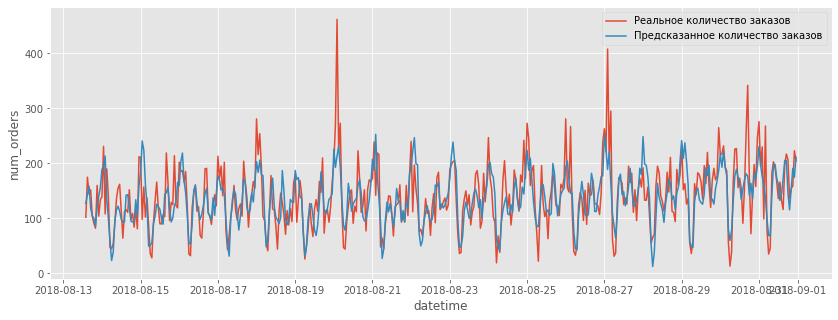

In [37]:
plt.figure(figsize=(14, 5))
plt.style.use('ggplot')
data = df_compare['2018-08-13':]
sns.lineplot(x=data.index, y=data['num_orders'], label='Реальное количество заказов');
sns.lineplot(x=data.index, y=data['pred'], label='Предсказанное количество заказов');

Модель достаточно хорошо предсказывает количество заказов, при этом есть потенциал улучшения: в некоторые дни количество заказов значительно завышено.

# Выводы

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, необходимо было спрогнозировать количество заказов такси на следующий час.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Данные были проанализированы:
* Данные представлены с 1 марта 2018 по 31 августа 2018 года
* Наибольшее количество поездок совершается около полуночи, наименьшее около 6 часов утра.
* В воскресенья и вторники поездок меньше всего, а в понедельники и пятницы - больше всего
* Есть тренд на увеличение количества заказов от месяца к месяцу. Поскольку данные предоставлены только за часть года, невозможно сказать, есть ли сезонная составляющая в росте количества поездок.
* Незаполненных значений нет.

Были исследованы три модели: линейная регрессия, lasso, lightGBM. Модели показали очень похожий результат RMSE, поэтому была выбрана более простая модель - линейная регрессия. На тестовых данных RMSE равен 40.94, модели довольно хорошо предсказывает сезонные особенности, но в ряде случаев завышает количество заказов.